In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind , pearsonr ,chi2_contingency
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings('ignore')

#pour les tableaux
import plotly.graph_objects as go

In [2]:
#Chargement des données et vérification des informations - fichier issu du notebook "meteo_4_construction de la base"
data_meteo=pd.read_csv(r"C:\DATA\meteo\data_meteo_traité.csv")
data_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391723 entries, 0 to 391722
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID_station       391723 non-null  int64  
 1   Station          391723 non-null  object 
 2   Latitude         391723 non-null  float64
 3   Longitude        391723 non-null  float64
 4   Altitude         391723 non-null  int64  
 5   distance_Paris   391723 non-null  float64
 6   Date_jour        391723 non-null  object 
 7   Année            391723 non-null  int64  
 8   Numéro_mois      391723 non-null  int64  
 9   Mois             391723 non-null  object 
 10  Température_max  391723 non-null  float64
 11  Jours>30°C       391723 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 35.9+ MB


In [3]:
#Nombre de stations et nombre de lignes
liste_stations=list(data_meteo["ID_station"].unique())
print("Le nombre de stations est:",len(liste_stations))
print("Nombre de lignes du du fichier data_meteo:",data_meteo.shape[0])

#Rappel : sur les 27 ans il y a 9857 dates , soit un manque de 5 jours

Le nombre de stations est: 40
Nombre de lignes du du fichier data_meteo: 391723


In [4]:
#Conservation des infos de station dans un dataframe info_stations
info_stations=data_meteo[["ID_station","Station","Latitude","Longitude","Altitude"]].drop_duplicates()
info_stations=info_stations.reset_index(drop=True)

In [5]:
# PARTIE A : statistiques globales

In [6]:
#Anova sur Température_max , avec les variables "Latitude","Longitude","Altitude","Année","Numéro_mois"
df=data_meteo
var_cible="Température_max"
variables=["Latitude","Longitude","Altitude","Année","Numéro_mois"]

valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(2))
    pval.append((anova["PR(>F)"][0]).round(3))

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova

#Effet significatif de toutes les variables 
#On note que la variable année est en dernière position ( classement par valeur de F décroissante)

Résultat des anova sur la variable cible:

Variable cible : Température_max


variable  valeur de F  p-value
0     Latitude     18340.02      0.0
1  Numéro_mois     12479.62      0.0
2    Longitude      4045.47      0.0
3     Altitude      2215.60      0.0
4        Année      1081.06      0.0

In [7]:
#Export tableau 1
df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Résultats Anova : Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau1.png")

In [8]:
#Corrélation de Température_max , avec les variables "Latitude","Longitude","Altitude","Année","Numéro_mois"
#Cela donnera les sens de variation 
df=data_meteo
var_cible=df["Température_max"]
variables=["Latitude","Longitude","Altitude","Année","Numéro_mois"]

coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for var in variables: 
    var_test=df[var]
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
corr_tmax=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                          "ord. à l'origine":ordorig}) 

corr_tmax

#Résultats statistiques conformes à l' anova
#La corrélation avec l'année est positive

variable  correlation  p-value   pente  ord. à l'origine
0     Latitude      -0.2115      0.0 -0.6699             47.60
1    Longitude       0.1011      0.0  0.2245             16.09
2     Altitude      -0.0750      0.0 -0.0027             17.08
3        Année       0.0525      0.0  0.0509            -85.65
4  Numéro_mois       0.1757      0.0  0.3848             14.10

In [9]:
# En synthèse

#La latitude l'emporte "largement" par rapport aux autres variables comme explication de la variance
# de la température max.

#L'effet saisonnier est le deuxième effet, à travers la variable mois 


In [10]:
#Paramètres généraux pour les graphiques
couleur_axes="dimgray"
couleur_texte="darkslategray"
liste_années=[1996,2004,2013,2022]
liste_mois=["Jan","Fev","Mar","Avr","Mai","Juin","Juil","Août","Sep","Oct","Nov","Dec"]
liste_stations=["LILLE-LESQUIN","MARIGNANE","NANTES-BOUGUENAIS","DIJON-LONGVIC"]


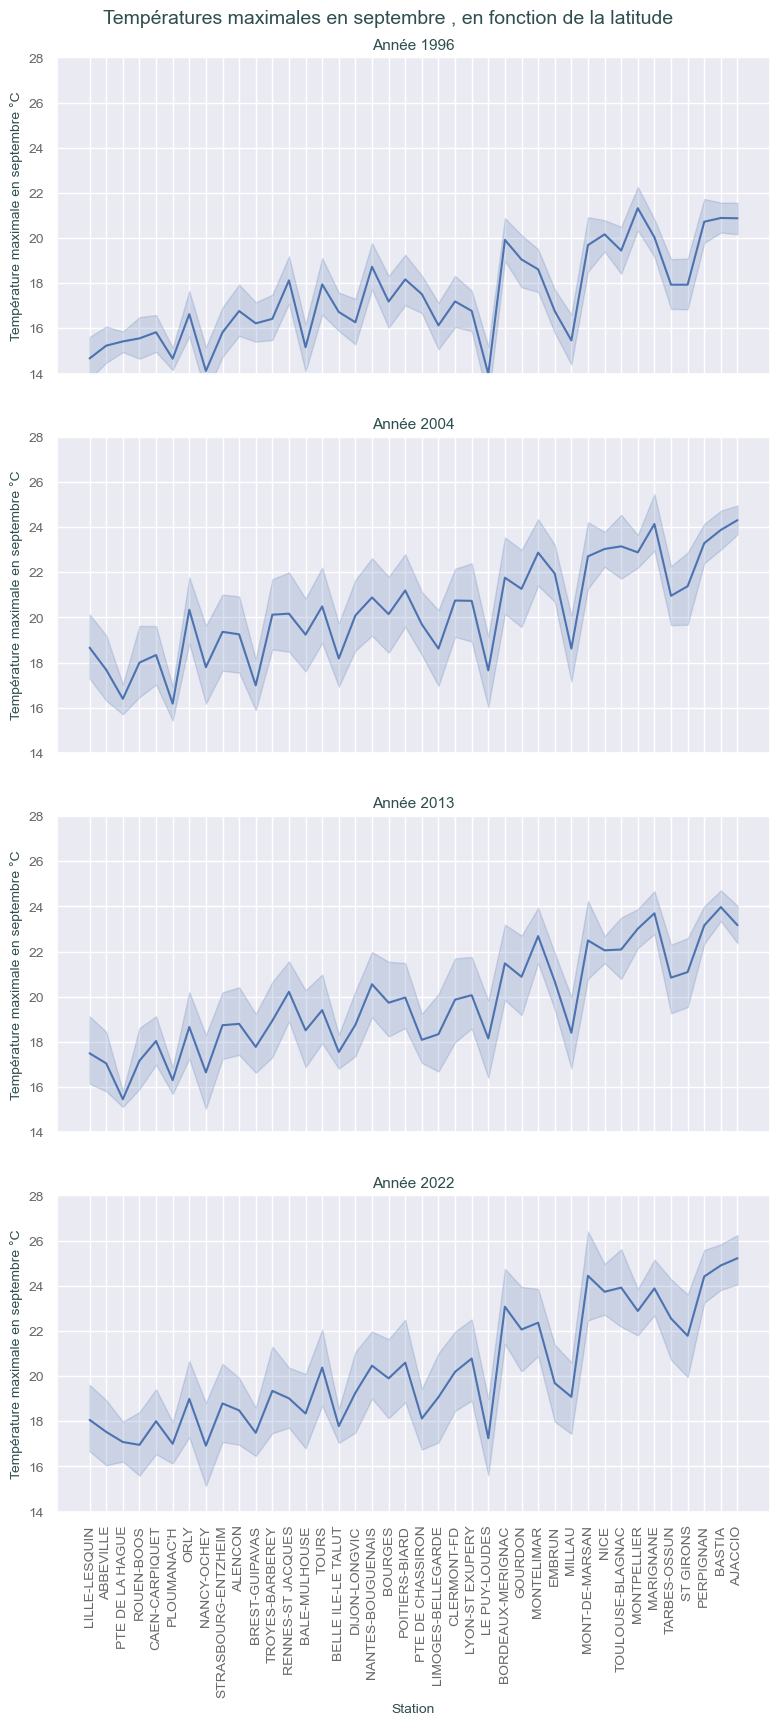

In [11]:
#Illustration de l'effet latitude sur température max en septembre

df=data_meteo[(data_meteo["Mois"]=="Septembre")&(data_meteo["Année"].isin(liste_années))]
df=df.sort_values(by="Latitude",ascending=False)

fig = sns.FacetGrid(df,  col="Année",col_wrap=1, margin_titles=True ,height=4,aspect=2,despine=False)
fig.map(sns.lineplot, "Station", "Température_max")
fig.figure.subplots_adjust(wspace=0.2, hspace=.2)
fig.set(ylim=(16, 30))

fig.set_xticklabels(color=couleur_axes,rotation=90,size=10)
fig.set_yticklabels(color=couleur_axes,size=10)
fig.set_axis_labels("Station","Température maximale en septembre °C",color=couleur_texte,size=10)
fig.set_titles(col_template="Année {col_name}",color=couleur_texte,size=11)
plt.subplots_adjust(top=0.95)
plt.suptitle("Températures maximales en septembre , en fonction de la latitude",size=14,color=couleur_texte);
#graphe1
fig.savefig("meteo_graphe1")    

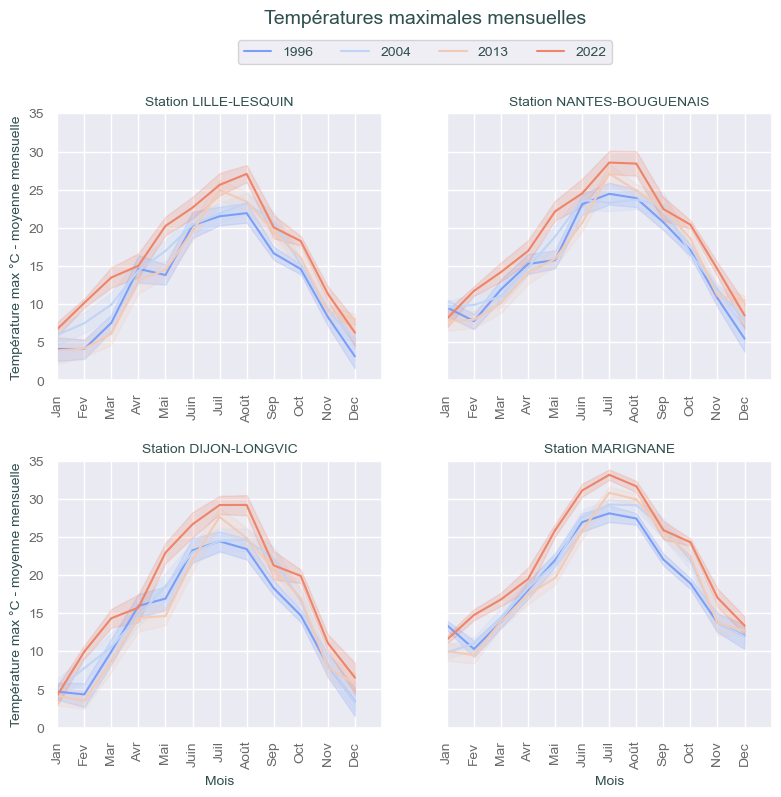

In [12]:
#Effet mois pour la liste de stations et d'années
#Illustration de la dépendance de température max versus mois

df=data_meteo[(data_meteo["Année"].isin(liste_années))&(data_meteo["Station"].isin(liste_stations))] 
fig = sns.FacetGrid(df,  col="Station",col_wrap=2,hue="Année",sharex=False,
                  palette="coolwarm", margin_titles=True ,height=4,despine=False)
fig.map(sns.lineplot, "Mois", "Température_max")
fig.figure.subplots_adjust(wspace=0.2, hspace=.3)
fig.set( ylim=(0, 35),xlim=(1,12))
fig.set_xticklabels(labels=liste_mois,rotation=90,color=couleur_axes,size=10)
labely=[0,5,10,15,20,25,30,35]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_axis_labels("Mois","Température max °C - moyenne mensuelle",color=couleur_texte,size=10)
fig.set_titles(col_template="Station {col_name}",color=couleur_texte,size=10)

fig.add_legend()
sns.move_legend(fig,"upper center",bbox_to_anchor=(.5, 0.95), ncol=4,
                frameon=True ,title=None,
                fontsize=10,labelcolor=couleur_texte,
               )
plt.subplots_adjust(top=0.85)
plt.suptitle("Températures maximales mensuelles",size=14,color=couleur_texte);
#graphe2
fig.savefig("meteo_graphe2")    

In [13]:
#Examen du mois de juillet pour les 4 stations au cours des années
#Analyse corrélation des mois de juillet pour les 4 stations

df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Mois"]=="Juillet")] 
nom_station=[]
coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for nom in liste_stations: 
    var_cible=df[df["Station"]==nom]["Température_max"]
    var_test=df[df["Station"]==nom]["Année"]
    nom_station.append(nom)
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
corr_station=pd.DataFrame({"Station":nom_station,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                           "ord. à l'origine":ordorig}) 

corr_station

Station  correlation  p-value   pente  ord. à l'origine
0      LILLE-LESQUIN       0.2158      0.0  0.1143           -206.53
1          MARIGNANE       0.2822      0.0  0.0987           -168.24
2  NANTES-BOUGUENAIS       0.1892      0.0  0.1019           -180.32
3      DIJON-LONGVIC       0.2250      0.0  0.1302           -235.67

In [14]:
#Export tableau 2
#Pour l'affichage les noms de stations sont raccourcis
df_tabl=corr_station
df_tabl=df_tabl.rename({"Station":"station"},axis=1)
df_tabl["station"]=df_tabl["station"].apply(lambda x:x.split("-")[0])
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>station</b>","<b>correlation</b>","<b>p-value</b>","<b>pente</b>","<b>ord. à l'origine</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=600, height=500,title_text="<b>Corrélation entre Température max. et Année</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau2.png")

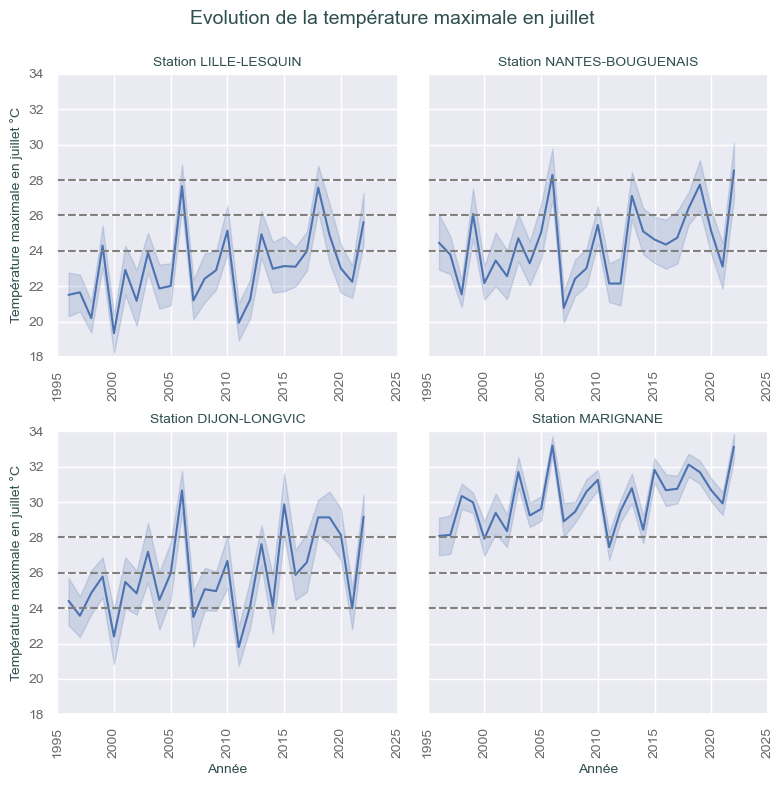

In [15]:
#Graphiques de la température maximale en juillet au cours des années
df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Mois"]=="Juillet")] 
fig = sns.FacetGrid(df,  col="Station",col_wrap=2,sharex=False,
                  palette="coolwarm", margin_titles=True ,height=4,despine=False)
#fig.map(sns.lineplot, "année", "pred",color="red")
fig.map(sns.lineplot, "Année", "Température_max")
fig.figure.subplots_adjust(wspace=0.2, hspace=.4)
fig.set(xlim=(1996,2022),ylim=(18, 34))
labelx=[1995,2000,2005,2010,2015,2020,2025]
liste_années=np.unique(data_meteo["Année"])
fig.set_xticklabels(labels=labelx,rotation=90,color=couleur_axes,size=10)
labely=[18,20,22,24,26,28,30,32,34]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_titles(col_template="Station {col_name}",color=couleur_texte,size=10)
fig.set_axis_labels("Année", "Température maximale en juillet °C",color=couleur_texte,size=10)

fig.refline(y=24)
fig.refline(y=26)
fig.refline(y=28)

plt.subplots_adjust(top=0.9)
plt.suptitle("Evolution de la température maximale en juillet",color=couleur_texte,size=14)
#graphe3
fig.savefig("meteo_graphe3")  


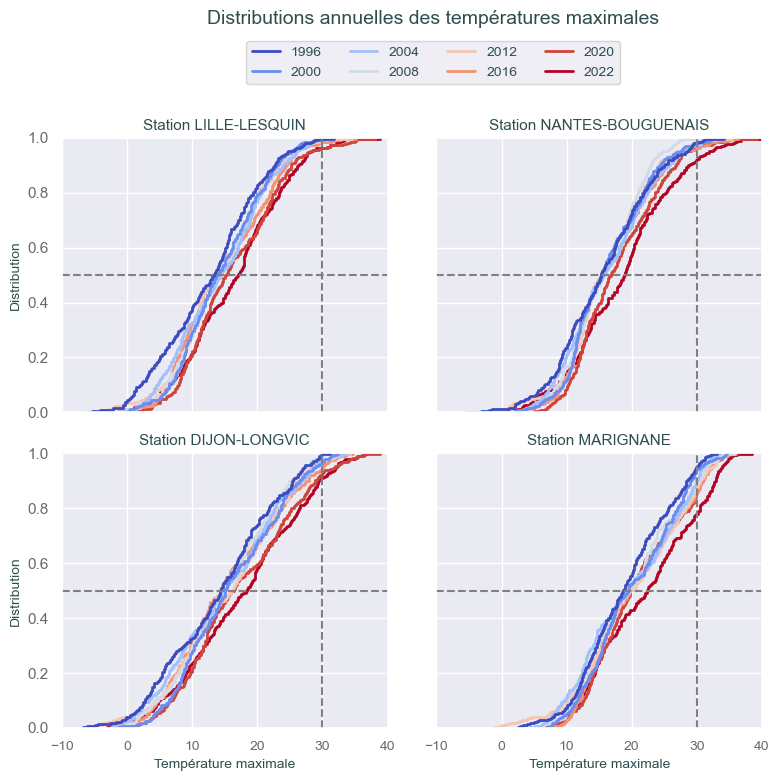

In [16]:
#Evolution de la distribution des températures max
#Distribution des températures maximales poour une sélection de 8 années et les 4 stations choisies
val_test=[1996,2000,2004,2008,2012,2016,2020,2022]
var_cible="Température_max"
var_test="Année"  
labely=[0.0,0.2,0.4,0.6,0.8,1.0]

df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Année"].isin(val_test))]
    
fig=sns.displot(data=df,x=var_cible,kind="ecdf", hue="Année",col="Station",col_wrap=2,
            height=4,aspect=1,palette="coolwarm",linewidth=2,
            facet_kws={ "margin_titles":True,"despine":False }                
            )
fig.refline(y=0.5,x=30)
fig.figure.subplots_adjust(wspace=0.15, hspace=0.15)
fig.set(xlim=(-10, 40),ylim=(0,1))
fig.set_xticklabels(color=couleur_axes,size=10)
fig.set_yticklabels(labels=labely,color=couleur_axes)
fig.set_titles(col_template="Station {col_name}",color=couleur_texte,size=11)
fig.set_axis_labels("Température maximale", "Distribution",color=couleur_texte,size=10)
sns.move_legend(fig,"upper center",bbox_to_anchor=(.5, 0.95), ncol=4,
                frameon=True ,title=None,
                fontsize=10,labelcolor=couleur_texte,
               )
plt.subplots_adjust(top=0.82)
plt.suptitle("Distributions annuelles des températures maximales",color=couleur_texte,size=14)

#graphe 4
fig.savefig("meteo_graphe4")      

In [17]:
#On note un glissement des distributions vers les températures plus élevées:

# premier axe : l'évolution de la moyenne des distributions et la quantification des écarts , 

# deuxième axe : l'évolution du nombre de jours à plus de 30°C au cours des années , queue de la distribution


In [18]:
# AXE1 : écart moyenne - Cartographie travail sur l'écart 1996-2022 

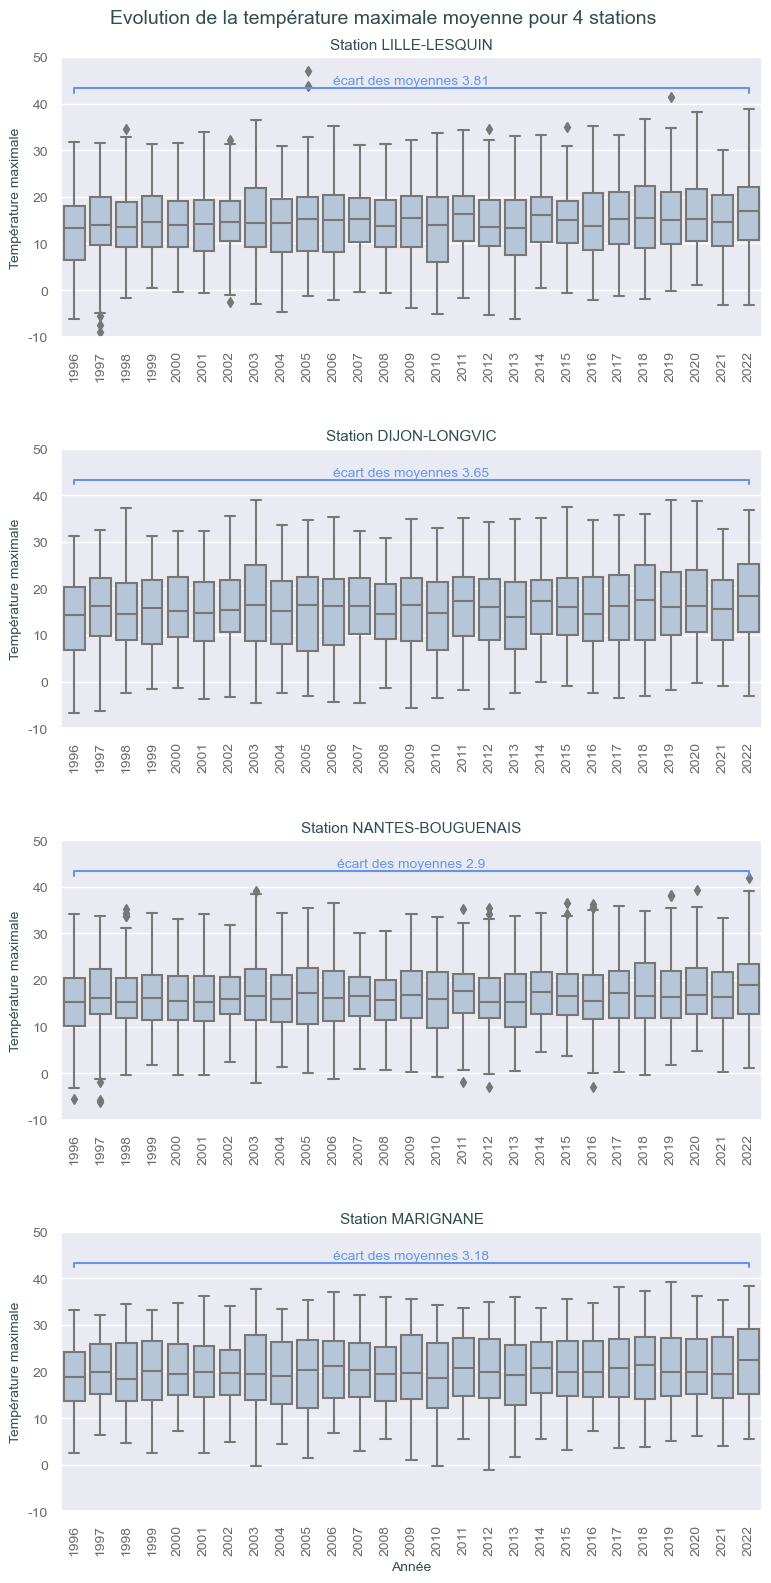

In [19]:
#Graphique d'évolution des écarts pour 4 stations

var_cible="Température_max"
var_test="Année"  

df=data_meteo[data_meteo["Station"].isin(liste_stations)]
df=df.sort_values(by="Latitude",ascending=False)

fig = sns.FacetGrid(df,  col="Station",col_wrap=1, margin_titles=True ,height=4,aspect=2,
                    sharex=False,sharey=False,despine=False)
fig.map(sns.boxplot, "Année", "Température_max",color="lightsteelblue")

fig.figure.subplots_adjust(wspace=0.2, hspace=.4)
fig.set(ylim=(-10, 50))
labely=[-10,0,10,20,30,40,50]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_xticklabels(color=couleur_axes,rotation=90,size=10)
fig.set_titles(col_template="Station {col_name}",color=couleur_texte,size=11)
fig.set_axis_labels("Année","Température maximale", color=couleur_texte,size=10)

for (col_val), ax in fig.axes_dict.items():
    x1, x2 = 0, 26   # columns '1996' and '2022' 
    moy2022=df[(df["Année"]==2022) & (df["Station"]==col_val)][var_cible].mean()
    moy1996=df[(df["Année"]==1996) & (df["Station"]==col_val)][var_cible].mean()
    ecartmoy=(moy2022-moy1996).round(2)
    y, h, couleur_annot = df[df["Année"]==2022]['Température_max'].max() +0.5, 1, 'cornflowerblue'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=couleur_annot)
    ax.text((x1+x2)*.5, y+h+0.2,"écart des moyennes "+ str(ecartmoy), ha='center', va='bottom', color=couleur_annot,size=10)  


plt.subplots_adjust(top=0.95)
plt.suptitle("Evolution de la température maximale moyenne pour 4 stations",color=couleur_texte,size=14)
#graphe 5
fig.savefig("meteo_graphe5")  



In [20]:
#Calcul des écarts entre 1996 et 202 pour toutes les stations
#Test statistique de Student 

val_test=[1996,2022]

var_cible="Température_max"
var_test="Année"  

station=[]
cond_0=[]
cond_1=[]
t_stat=[]
p_val=[]
ecart=[]
test=[]
liste_test=list(data_meteo["Station"].unique())

for nom in liste_test:
    
    for i in range(len(val_test)):
        df=data_meteo[(data_meteo["Année"].isin(val_test))&(data_meteo["Station"]==nom)]
        for j in np.arange(i+1,len(val_test),1):
            config_0=df[var_cible][df[var_test]==val_test[i]]
            config_1=df[var_cible][df[var_test]==val_test[j]]
            student = ttest_ind(config_0,config_1)
            station.append(nom)
            cond_0.append(val_test[i])
            cond_1.append(val_test[j])
            t_stat.append(student[0].round(4))
            p_val.append(student[1].round(4))
            if student[1]<=0.05:
                resul="oui"
            else:
                resul="non"        
            ecartmoy=(config_1.mean()-config_0.mean()).round(3)
            ecart.append(ecartmoy)
            test.append(resul)
df_ecart=pd.DataFrame({"Station":station,"test_0":cond_0,"test_1":cond_1,"ecart moyenne":ecart,"stat t":t_stat,"p-value":p_val,"<=0.05":test}) 
df_ecart=df_ecart.sort_values(by="ecart moyenne",ascending=False).reset_index(drop=True)

In [21]:
df_ecart

Station  test_0  test_1  ecart moyenne  stat t  p-value <=0.05
0   STRASBOURG-ENTZHEIM    1996    2022          4.469 -6.5898   0.0000    oui
1         BALE-MULHOUSE    1996    2022          4.272 -6.4344   0.0000    oui
2           NANCY-OCHEY    1996    2022          4.139 -6.3224   0.0000    oui
3         LE PUY-LOUDES    1996    2022          3.825 -6.2612   0.0000    oui
4         LILLE-LESQUIN    1996    2022          3.813 -6.7353   0.0000    oui
5       LYON-ST EXUPERY    1996    2022          3.808 -5.9483   0.0000    oui
6                EMBRUN    1996    2022          3.784 -6.1520   0.0000    oui
7                MILLAU    1996    2022          3.676 -6.0381   0.0000    oui
8         DIJON-LONGVIC    1996    2022          3.647 -5.5979   0.0000    oui
9           CLERMONT-FD    1996    2022          3.635 -6.0117   0.0000    oui
10           MONTELIMAR    1996    2022          3.629 -5.7107   0.0000    oui
11      TROYES-BARBEREY    1996    2022          3.561 -5.6987   0.0000    oui
12            ABBEVILLE    1996    2022          3.497 -6.4904   0.0000    oui
13            ST GIRONS    1996    2022          3.472 -6.4142   0.0000    oui
14     TOULOUSE-BLAGNAC    1996    2022          3.420 -5.6941   0.0000    oui
15                TOURS    1996    2022          3.330 -5.4770   0.0000    oui
16              BOURGES    1996    2022          3.284 -5.3586   0.0000    oui
17         TARBES-OSSUN    1996    2022          3.264 -6.0791   0.0000    oui
18                 ORLY    1996    2022          3.210 -5.3547   0.0000    oui
19            MARIGNANE    1996    2022          3.184 -5.9144   0.0000    oui
20   LIMOGES-BELLEGARDE    1996    2022          3.150 -5.6140   0.0000    oui
21           ROUEN-BOOS    1996    2022          3.076 -5.4011   0.0000    oui
22       MONT-DE-MARSAN    1996    2022          3.020 -5.2281   0.0000    oui
23            PERPIGNAN    1996    2022          2.971 -5.6918   0.0000    oui
24              AJACCIO    1996    2022          2.933 -6.5496   0.0000    oui
25       POITIERS-BIARD    1996    2022          2.912 -4.9121   0.0000    oui
26    NANTES-BOUGUENAIS    1996    2022          2.903 -5.2025   0.0000    oui
27              ALENCON    1996    2022          2.871 -5.0154   0.0000    oui
28       CAEN-CARPIQUET    1996    2022          2.597 -5.1679   0.0000    oui
29    BORDEAUX-MERIGNAC    1996    2022          2.590 -4.5847   0.0000    oui
30    RENNES-ST JACQUES    1996    2022          2.589 -4.7905   0.0000    oui
31              GOURDON    1996    2022          2.581 -4.2751   0.0000    oui
32       BREST-GUIPAVAS    1996    2022          2.480 -6.0155   0.0000    oui
33          PLOUMANAC'H    1996    2022          2.450 -6.7354   0.0000    oui
34               BASTIA    1996    2022          2.318 -4.8202   0.0000    oui
35   BELLE ILE-LE TALUT    1996    2022          2.289 -5.6387   0.0000    oui
36                 NICE    1996    2022          2.047 -4.7338   0.0000    oui
37          MONTPELLIER    1996    2022          2.035 -3.8138   0.0001    oui
38      PTE DE LA HAGUE    1996    2022          1.846 -5.3379   0.0000    oui
39     PTE DE CHASSIRON    1996    2022          1.815 -3.8504   0.0001    oui

In [22]:
#Description statistique succincte
df_ecart[["ecart moyenne"]].describe()

#Les écarts des moyennes entre 1996 et 2022 , sont significatifs pour toutes les stations.
#La moyenne est 3.1°C

ecart moyenne
count      40.000000
mean        3.109800
std         0.660893
min         1.815000
25%         2.589750
50%         3.167000
75%         3.630500
max         4.469000

In [23]:
#Export tableau 3 ( 5 plus gros écarts et 5 plus petits écarts)

df_ecart_max=df_ecart.head(5)
df_ecart_min=df_ecart.tail(5)
df_tabl=pd.concat([df_ecart_max,df_ecart_min],axis=0)
df_tabl=df_tabl.drop(["test_0","test_1","<=0.05"],axis=1)
df_tabl["classement"]=[1,2,3,4,5,36,37,38,39,40]
df_tabl["Station"]=df_tabl["Station"].apply(lambda x:x.split("-")[0])
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>station</b>","<b>écart(°C)</b>","<b>statistique t</b>","<b>p-value</b>","<b>classement</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=870, height=500,title_text="<b>5 plus forts et 5 plus faibles écarts 1996/2022 sur la moyenne de Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau3.png")

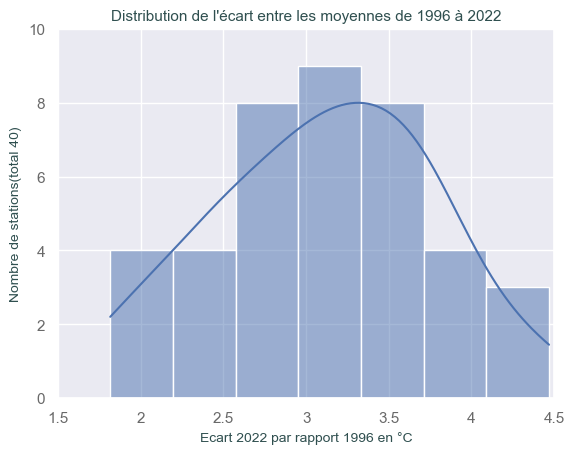

In [24]:
#Distribution des écarts

fig, ax = plt.subplots()
sns.histplot(df_ecart["ecart moyenne"],ax=ax ,kde=True)
ax.set(xlim=(1.5,4.5),ylim=(0,10))
labelx=[1.5,2,2.5,3,3.5,4,4.5]
ax.set_xticklabels(labels=labelx,color=couleur_axes)
labely=[0,2,4,6,8,10]
ax.set_yticklabels(labels=labely,color=couleur_axes)
ax.set_xlabel("Ecart 2022 par rapport 1996 en °C",color=couleur_texte,size=10)
ax.set_ylabel("Nombre de stations(total 40)",color=couleur_texte,size=10)
ax.set_title("Distribution de l'écart entre les moyennes de 1996 à 2022",color=couleur_texte,size=11)


#graphe 6
fig.savefig("meteo_graphe6")

In [25]:
#Préparation des données pour une carte des écarts entre 1996 et 2022

#Ajout d'une variable classe écart de température
nom_classes=["moins de 2°C","de 2 à 3°C","de 3 à 4°C","plus de 4°C"]
liste_classes=[-10,2,3,4,100]

df_ecart["Classe_écart"]=pd.cut(df_ecart["ecart moyenne"],bins=liste_classes,
                                              labels=nom_classes) 

#Ajout des informations de station , nom , Latitude , Longitude,Altitude
df_ecart=df_ecart.merge(right=info_stations,on="Station",how="inner")


In [26]:
#Carte des écarts entre moyennes de 1996 et 2022
df_ecart=df_ecart[['ID_station','Station','ecart moyenne', 'Classe_écart', 'Latitude', 'Longitude','Altitude']]

#Création du géo dataframe
df_ecart_geo=gpd.GeoDataFrame(df_ecart,geometry=gpd.points_from_xy(df_ecart["Longitude"],df_ecart["Latitude"]))                         
df_ecart_geo=df_ecart_geo.set_crs(epsg="4326")

liste_couleurs=["darkgreen","deepskyblue","orange","red"]
kargs={"location":[47,3],"zoom_start":6.}
fig=df_ecart_geo.explore(tooltip=True,
                     marker_kwds={"radius":8,"fill":True },
                     style_kwds={"fillOpacity":1},
                     column="Classe_écart",
                     legend_kwds={"caption":"Ecart en °C"},
                     cmap=liste_couleurs,
                     legend=True,
                     map_kwds={"scrollWheelZoom":False},
                     **kargs,
    
)
fig


In [27]:
#graphe 7
fig.save("meteo_graphe7")

In [28]:
#Test Anova sur les écarts entre 1996 et 2022 
df_testecart=df_ecart_geo[["ecart moyenne","Longitude","Latitude","Altitude"]]
df_testecart=df_testecart.rename({"ecart moyenne":"ecart_moyenne"},axis=1)
var_cible="ecart_moyenne"
Col=["Latitude","Longitude","Altitude"]

valeur_F=[]
pval=[]
for var_expl in Col:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df_testecart).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(3))
    pval.append((anova["PR(>F)"][0]).round(4))

df_anova=pd.DataFrame({"variable":Col,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova


#Dans le cas de la latitude  on ne peut peut rejeter l'hypothèse nulle.
#Il n'y a pas d'effet de la latitude sur l' écart entre les moyennes 1996 et 2022.


Résultat des anova sur la variable cible:

Variable cible : ecart_moyenne


variable  valeur de F  p-value
0   Altitude       14.448   0.0005
1  Longitude       11.490   0.0016
2   Latitude        0.434   0.5142

In [29]:
#Export tableau 4

df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Anova Ecart 1996/2022 sur moyenne de Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau4.png")

In [30]:
# AXE 2
# Nombre de jours > 30°C par année et par station

In [31]:
#Anova avec jours>30°C par année
df=data_meteo.groupby(["Latitude","Longitude","Altitude","Année"],as_index=False).agg({"Jours>30°C":"sum"})
df=df.rename({"Jours>30°C":"Jours_sup30"}, axis=1)  #on renomme pour le test anova (pb des blancs)
var_cible="Jours_sup30"
variables=["Latitude","Longitude","Altitude","Année"]

valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(2))
    pval.append((anova["PR(>F)"][0]).round(4))

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova


#Dans le cas de l'altitude  on ne peut peut rejeter l'hypothèse nulle.
#Il n'y a pas d'effet de l'altitude sur le nombre de jours >30°C.



Résultat des anova sur la variable cible:

Variable cible : Jours_sup30


variable  valeur de F  p-value
0   Latitude       321.04   0.0000
1  Longitude       129.52   0.0000
2      Année        75.73   0.0000
3   Altitude         0.08   0.7768

In [32]:
#Corrélation de Jours>30°C , avec les variables "Latitude","Longitude","Altitude","Année"
#Cela donnera les sens de variation
var_cible=df["Jours_sup30"]
variables=["Latitude","Longitude","Altitude","Année"]

coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for var in variables: 
    var_test=df[var]
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
df_correl=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                          "ord. à l'origine":ordorig}) 

df_correl

#La corrélation avec année est positive

variable  correlation  p-value   pente  ord. à l'origine
0   Latitude      -0.4790   0.0000 -2.6497            136.23
1  Longitude       0.3275   0.0000  1.2690             10.75
2   Altitude      -0.0086   0.7768 -0.0005             13.75
3      Année       0.2562   0.0000  0.4338           -857.89

In [33]:
#Export tableau 5
df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Résultats Anova : Jours à température >30°C</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau5.png")

In [34]:
#Export tableau 6
df_tabl=df_correl
variable=[df_tabl[var] for var in df_tabl.columns] 
entêtes=["<b>variable</b>","<b>correlation</b>","<b>p-value</b>","<b>pente</b>","<b>ord.origine</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4,5],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=530, height=500,title_text="<b>Résultats pearsonr : Jours à température >30°C</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau6.png")

In [35]:
#Création d'un dataframe de regroupement annuel par station pour préparer les graphiques et les cartes

df_annuel=data_meteo.groupby(["ID_station","Année"],as_index=False).agg({"Jours>30°C":"sum"})

#Ajout des informations de station , nom , Latitude , Longitude,Altitude
df_annuel=df_annuel.merge(right=info_stations,on="ID_station",how="inner")

#Ajout d'une variable classe de nombre de jours
nom_classes=["moins de 10 j","de 10 à 20 j","de 20 à 30 j","de 30 à 40 j","plus de 40 j"]
liste_classes=[-10,10,20,30,40,100]

df_annuel["Classe_jours"]=pd.cut(df_annuel["Jours>30°C"],bins=liste_classes,
                                              labels=nom_classes) 
#Ajouts des couleurs pour les cartes
liste_couleurs=["darkgreen","deepskyblue","blueviolet","chocolate","red"]
df_couleurs=pd.DataFrame({"Classe_jours":nom_classes,"couleur":liste_couleurs})

df_annuel=df_annuel.merge(right=df_couleurs,on="Classe_jours",how="inner")

#Création d'un geodataframe

df_annuel_geo=gpd.GeoDataFrame(df_annuel,geometry=gpd.points_from_xy(df_annuel["Longitude"],df_annuel["Latitude"]))                         
df_annuel_geo=df_annuel_geo.set_crs(epsg="4326")


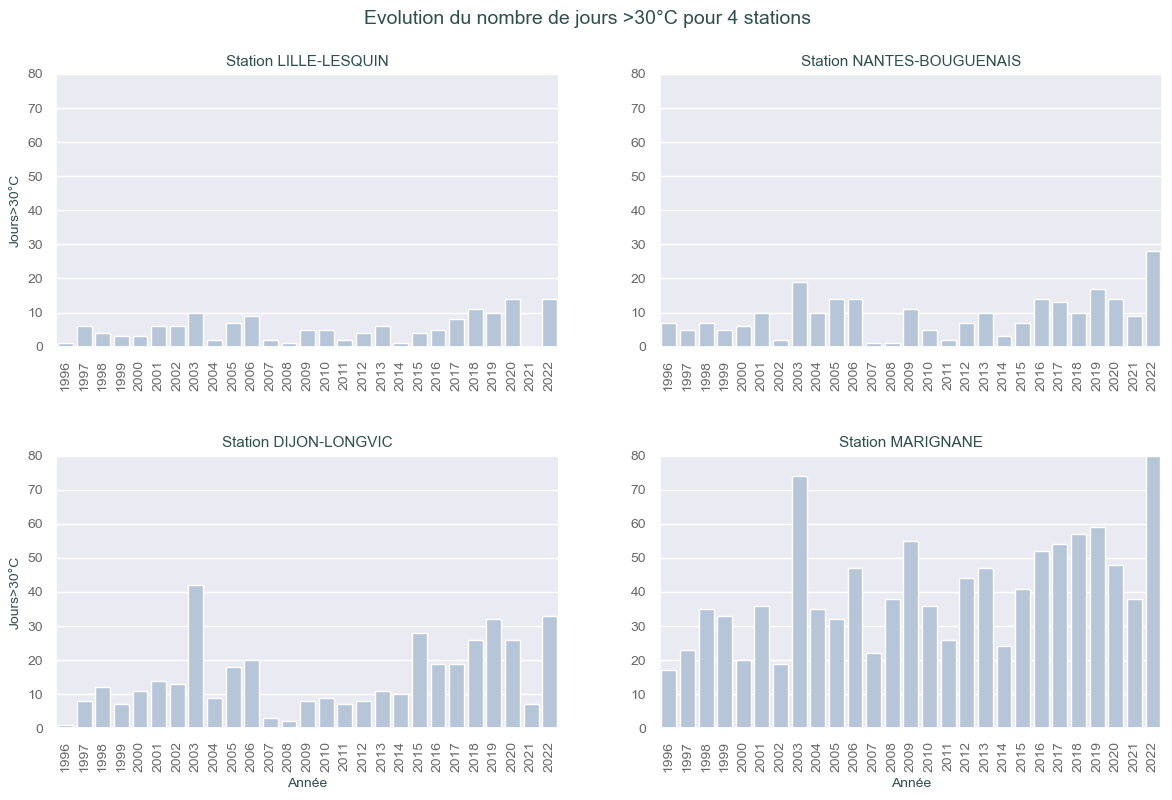

In [36]:
#Graphique d'évolution du nombre de jours > 30°C pour  4 stations

var_cible="Jours>30°C"
var_test="Année"  

df=df_annuel[df_annuel["Station"].isin(liste_stations)]

fig = sns.FacetGrid(df,  col="Station",col_wrap=2, margin_titles=True ,height=4,aspect=1.5,
                    sharex=False,sharey=False,despine=False)
fig.map(sns.barplot, "Année", "Jours>30°C",color="lightsteelblue")

fig.figure.subplots_adjust(wspace=0.2, hspace=.4)
fig.set(ylim=(0, 80))

fig.set(yticks=[0,10,20,30,40,50,60,70,80])
labely=[0,10,20,30,40,50,60,70,80]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_xticklabels(color=couleur_axes,rotation=90,size=10)
fig.set_titles(col_template="Station {col_name}",color=couleur_texte,size=11)
fig.set_axis_labels("Année","Jours>30°C", color=couleur_texte,size=10)

plt.subplots_adjust(top=0.9)
plt.suptitle("Evolution du nombre de jours >30°C pour 4 stations",color=couleur_texte,size=14)
#graphe 8
fig.savefig("meteo_graphe8")  

#On note la spécificité de l'année 2003 pour 3 des stations
#On visualise la tendance à l'augmentation au cours des années

In [37]:
#Statistiques globales
df_annuel[["Jours>30°C"]].describe()

Jours>30°C
count  1080.000000
mean     13.657407
std      13.195164
min       0.000000
25%       3.000000
50%      10.000000
75%      20.000000
max      80.000000

In [38]:
df_annuel

ID_station  Année  Jours>30°C    Station   Latitude  Longitude  \
0           7005   1996           1  ABBEVILLE  50.136000   1.834000   
1           7005   1997           2  ABBEVILLE  50.136000   1.834000   
2           7005   1998           1  ABBEVILLE  50.136000   1.834000   
3           7005   1999           3  ABBEVILLE  50.136000   1.834000   
4           7005   2000           1  ABBEVILLE  50.136000   1.834000   
...          ...    ...         ...        ...        ...        ...   
1075        7747   2022          67  PERPIGNAN  42.737167   2.872833   
1076        7761   2003          42    AJACCIO  41.918000   8.792667   
1077        7761   2022          59    AJACCIO  41.918000   8.792667   
1078        7790   2003          60     BASTIA  42.540667   9.485167   
1079        7790   2022          55     BASTIA  42.540667   9.485167   

      Altitude   Classe_jours    couleur                  geometry  
0           69  moins de 10 j  darkgreen  POINT (1.83400 50.13600)  
1           69  moins de 10 j  darkgreen  POINT (1.83400 50.13600)  
2           69  moins de 10 j  darkgreen  POINT (1.83400 50.13600)  
3           69  moins de 10 j  darkgreen  POINT (1.83400 50.13600)  
4           69  moins de 10 j  darkgreen  POINT (1.83400 50.13600)  
...        ...            ...        ...                       ...  
1075        42   plus de 40 j        red  POINT (2.87283 42.73717)  
1076         5   plus de 40 j        red  POINT (8.79267 41.91800)  
1077         5   plus de 40 j        red  POINT (8.79267 41.91800)  
1078        10   plus de 40 j        red  POINT (9.48517 42.54067)  
1079        10   plus de 40 j        red  POINT (9.48517 42.54067)  

[1080 rows x 10 columns]

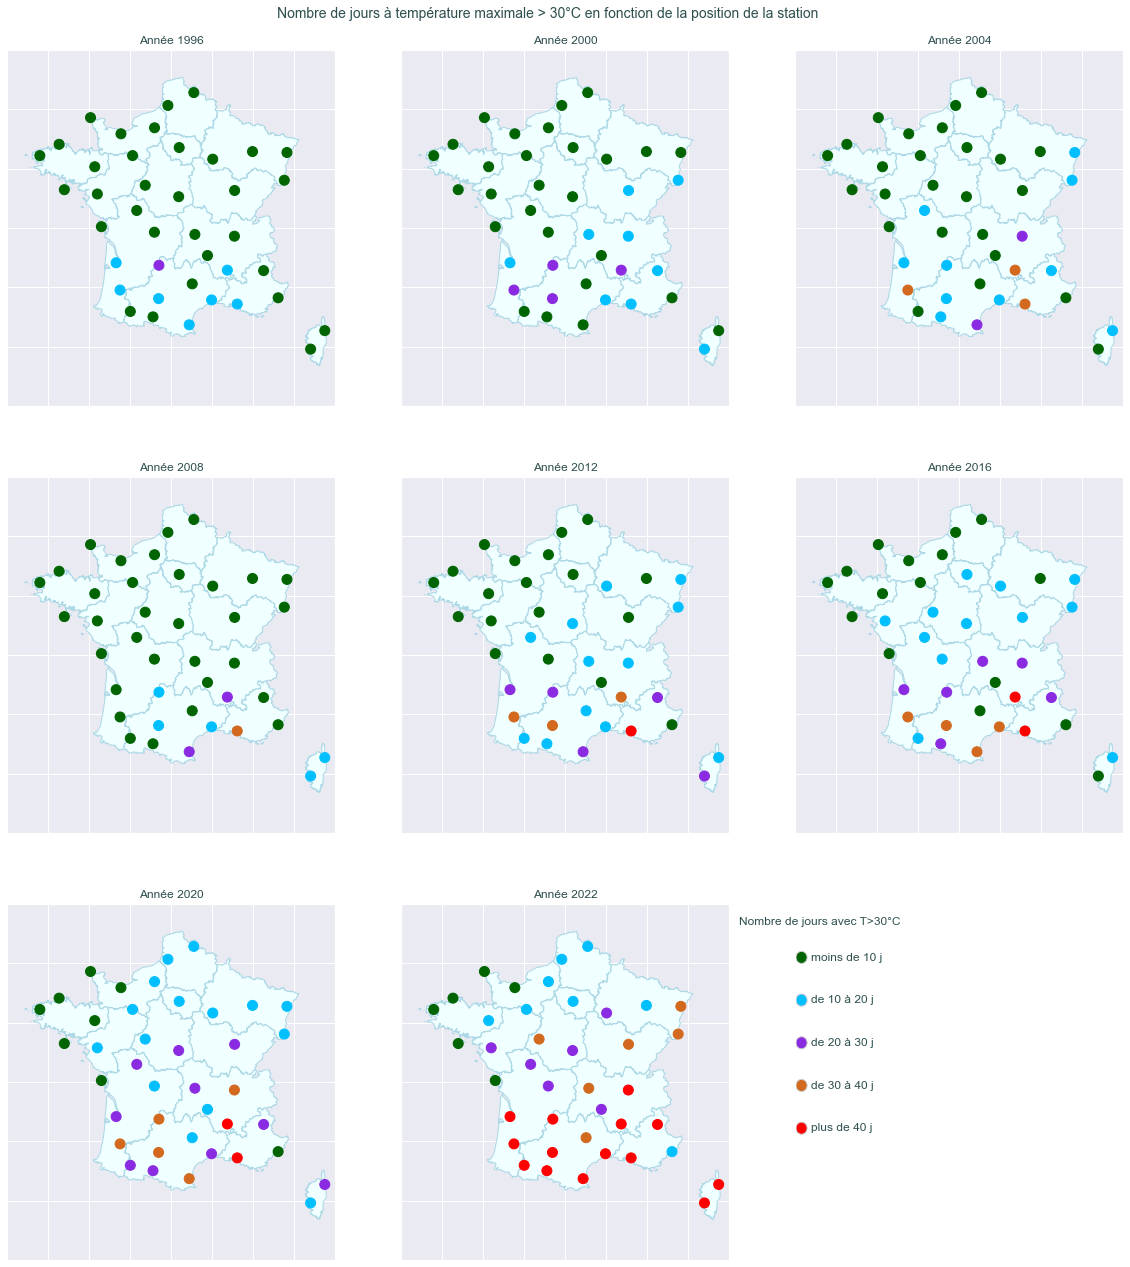

In [39]:
#Cartes de l'évolution du nombre de jours >30°C
from matplotlib.patches import Circle ,Rectangle

#Contour de carte des régions
régions=gpd.read_file(r"C:\DATA\contours_cartes\a-reg2020-geojson.json")
#Filtre pour enlever l'outremer
régions=régions[0:13]

#Choix des années
liste_années=[1996,2000,2004,2008,2012,2016,2020,2022]
nb_an=len(liste_années)
nb_col=3
nb_rg=nb_an // nb_col + int(nb_an % nb_col > 0)
largeur = 400 * nb_col 
hauteur = 400 * nb_rg 
dpi = 72

fig, ax = plt.subplots(figsize=(largeur / dpi*1.2, hauteur / dpi*1.2), dpi=dpi)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
style = dict(size=10, color='steelblue',ha="center",va="bottom")

for i in range(nb_an):
    ax = fig.add_subplot(nb_rg, nb_col, i+1)
    an=liste_années[i]
    df_geo=df_annuel_geo[df_annuel_geo["Année"]==an].reset_index(drop=True)
    régions.plot(ax=ax,color="azure",edgecolor="lightblue",linewidth=1)
    couleurs=list(df_geo["couleur"])
    labels=list(df_geo["Classe_jours"])
    df_geo.plot(ax=ax,markersize=100,marker="o",c=couleurs,label=labels)
    ax.set_title("Année "+str(df_geo["Année"][0]),fontdict={'fontsize':12,'color':couleur_texte})
    ax.set(xlim=(-6,10),ylim=(40,52))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#Ajout du graphe de légende

ax=fig.add_subplot(nb_rg, nb_col, nb_an +1)
ax.add_patch( Rectangle(xy=(0, 0), width=1,height=1,facecolor="white", edgecolor='0.5') )
ax.text(0.075, 0.95, "Nombre de jours avec T>30°C", fontsize=12,
            horizontalalignment='center',
            verticalalignment='center',
            color=couleur_texte)
for i in range(5):
    col = i
    larg=0.12
    ax.add_patch(Circle(xy=(0.02,0.85-i*larg), radius=0.017, facecolor=df_couleurs["couleur"][i], edgecolor='0.8'))       
    ax.text(0.05,0.85-i*larg, df_couleurs["Classe_jours"][i], fontsize=12,
            horizontalalignment='left',verticalalignment='center',color=couleur_texte)

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.subplots_adjust(top=0.95)
plt.suptitle("Nombre de jours à température maximale > 30°C en fonction de la position de la station",color=couleur_texte,size=14)
#graphe 9
fig.savefig("meteo_graphe9")   




In [40]:
#FIN ANALYSE